# KAIST AI605 Assignment 3: Tagging, Structured Prediction, HMM, CRF

## Rubric

### Deadline 
The deadline for this assignment is: Tuesday 25th October 2022 (Week 9) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit both (1) a PDF of your solutions and (2) the Jupyter Notebook file (.ipynb).

Use in-line LaTeX for mathematical expressions. 

### Collaboration
This assignment is not a group assignment so make sure your answer and code are your own.

### Grading
The total number of marks avaiable is 30 points.

### Environment
The use of a GPU is not required for this notebook. The required environment for this is Python 3.9. Run the following cell to set up the environment.

In [1]:
# pip install numpy torch nltk scikit-learn tqdm datasets

In [2]:
!python --version

Python 3.8.6rc1


## Problem 1: Tagging Datasets (4 points)

**Problem 1.1** (2 points) In some tagging problems, such as Named Entity Recognition, IOB and IOBES tagging formats are used. Explain the purpose of these tagging formats and describe the difference between IOB and IOBES tagging formats (max 200 words)



Purpose: The purpose of tagging is to catch specific values/names for our task. We want to have specific chuncks from whole sentence. 

Differences: In IOB we are coding inside, outside and begging with IOBES we are additionally coding ending and single word. IOB is not allowing any nesting like nested Named Entities (ex. Warsaw University of Technology).

**Problem 1.2** (2 points) A string is tagged with IOB tagging format as listed below. Write code to extract the tuples of the entities and entity types from the tagged string. (e.g. `[["Biden", "PERSON"], ...]`)

In [3]:
input_string = ["Biden", "was", "born", "and", "raised", "in", "Scranton", ",", "Pennsylvania", ",", "and",
                "moved", "with", "his", "family", "to", "Delaware", "in", "1953", "when", "he", "was", "ten", "years", "old", ".",
                "He", "studied", "at", "the", "University", "of", "Delaware", "before", "earning", "his", "law", "degree", "from",
                "Syracuse", "University","."]

tags          = ["B-PERSON", "O", "O", "O", "O", "O", "B-LOCATION", "I-LOCATION", "I-LOCATION", "O", "O",
                "O", "O", "O", "O", "O", "B-LOCATION", "O", "B-DATE", "O", "O", "O", "O", "O", "O", ".",
                "O", "O", "O", "O", "B-ORGANIZATION", "I-ORGANIZATION", "I-ORGANIZATION", "O", "O", "O", "O", "O", "O",
                "B-ORGANIZATION", "I-ORGANIZATION","O"]



In [4]:
tag_list = []
for i, string in enumerate(input_string):
    tag_list.append((string,tags[i]))

In [5]:
tag_list

[('Biden', 'B-PERSON'),
 ('was', 'O'),
 ('born', 'O'),
 ('and', 'O'),
 ('raised', 'O'),
 ('in', 'O'),
 ('Scranton', 'B-LOCATION'),
 (',', 'I-LOCATION'),
 ('Pennsylvania', 'I-LOCATION'),
 (',', 'O'),
 ('and', 'O'),
 ('moved', 'O'),
 ('with', 'O'),
 ('his', 'O'),
 ('family', 'O'),
 ('to', 'O'),
 ('Delaware', 'B-LOCATION'),
 ('in', 'O'),
 ('1953', 'B-DATE'),
 ('when', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('ten', 'O'),
 ('years', 'O'),
 ('old', 'O'),
 ('.', '.'),
 ('He', 'O'),
 ('studied', 'O'),
 ('at', 'O'),
 ('the', 'O'),
 ('University', 'B-ORGANIZATION'),
 ('of', 'I-ORGANIZATION'),
 ('Delaware', 'I-ORGANIZATION'),
 ('before', 'O'),
 ('earning', 'O'),
 ('his', 'O'),
 ('law', 'O'),
 ('degree', 'O'),
 ('from', 'O'),
 ('Syracuse', 'B-ORGANIZATION'),
 ('University', 'I-ORGANIZATION'),
 ('.', 'O')]

## Problem 2:  HMM and Viterbi Decoding (14 points)

As part of a mission to Mars, a rover performs ground surveys to study randomly sampled rocks. The mission is divided into four search areas (quadrants: A,B,C,D). The rover can move north-south and west-east between adjacent search areas such as `(A,B)`, `(A,C)`, but **can not** make diagonal moves between search areas such as `(A,D)` due to physical constraints. 

![nav.png](nav.png)


The rover samples a rock from the search quadrants with the following probabilities:


| Rock Type | Area A | Area B | Area C | Area D |
|---|---|---|---|---|
|Meteorite          | 50% |           20% |   10%  | 0%  |           
|Sandstone          | 40% |           30% |   60%  | 90% |          
|Igneous Rock       | 10% |           50% |   30%  | 10% |            


**Problem 2.1** (2 points) Navigation data sent to and received from the rover is corrupted. State how the path taken by the rover between the search quadrants could be recovered using a first order Hidden Markov Model given observations of the surveyed rocks. Describe modelling assumptions and relevant formula. Ignore start and end states for now.


 Assumptions:
 
 $P(y) = P(y_1)P(y_2|y_1)...P(y_m|y_1,...,y_{m-1})\approx\prod_{t=1}^{m}P(y_t|y_{t-1}) ->$ provided by the restriction of rover movements, each new area to which rover is moving depends on previous movement 
 
 $X ~ constant$ 
 
 Formulas: 
 
 
 $\prod_{t=1}^{m}P(y_t|y_{t-1})$ - probability of going to area $y_t$ given previous area $y_{t-1}$
 
 From A we can go only to B, C with 50% probability ect. -> assumption 
 
 $P(x_t|y_t)$ - probability of finding each rock type $x_t$ in given area $y_t$
 
 Decision on label: 
 
 $\hat Y = argmax\prod_{t=1}^{m}P(y_t|y_{t-1})P(x_t|y_t) $

**Problem 2.2** (2 points) Inspection of the corrupted navigation plans indicate that 50% of the time, the rover remains in the same quadrant. Otherwise, the rover randomly navigates along the north-south or west-east axis. Movements in the north-south axis occur twice as often as the west-east axis. Use this information to complete the parameter matrices for your Hidden Markov Model. 

**Provide your answer as two tensors/matrices using Numpy or PyTorch**

In [6]:
import torch
from tqdm.notebook import tqdm
import numpy as np 

|            | Area A | Area B | Area C | Area D |
|---|---|---|---|---|
|Area A      |    50% |        16.67% | 33.34%  |     0% |           
|Area B      | 16.67% |           50% |     0%  | 33.34% |          
|Area C      | 33.34% |            0% |    50%  | 16.67% |   
|Area D      |     0% |        33.34% | 16.67%  |    50% |    

In [101]:
#area by row, column each rock type
p_x_y = torch.Tensor([[0.5,0.4,0.1],[0.2,0.3,0.5],[0.1,0.6,0.3],[0,0.9,0.1]])

#area column and area by row 
p_y_yp = torch.Tensor([[0.5,1/6,2/6,0.],[1/6,0.5,0.,1/3],[1/3,0.,0.5,1/6],[0.,1/3,1/6,0.5]])

p_y_yp

tensor([[0.5000, 0.1667, 0.3333, 0.0000],
        [0.1667, 0.5000, 0.0000, 0.3333],
        [0.3333, 0.0000, 0.5000, 0.1667],
        [0.0000, 0.3333, 0.1667, 0.5000]])

**Problem 2.3** (2 points) Part of the data recovered from the rover indicates that the rover indicates that the rover identified the following sequence of rock types as `Sandstone, Meteorite, Meteorite, Igneous, Sandstone, Igneous, Sandstone`.

An researcher suggests two routes the rover could have taken: `A, A, A, B, D, B, D` or `D, C, C, C, A, A, A`

Use this information, combined with your answer from 2.2, to predict which path is most likely. What are the probabilities of these two paths? Do you observe any difference when scoring each path using log probabilities?

It is acceptable to use either Numpy or PyTorch for your answer. 

|           | 0 |             1 |        2|      3 |
|---|---|---|---|---|
|Meteorite       0   | 50% |           20% |   10%  | 0%  |           
|Sandstone       1   | 40% |           30% |   60%  | 90% |          
|Igneous Rock    2   | 10% |           50% |   30%  | 10% |   

|           | 0 |             1 |        2|      3 |
|---|---|---|---|---|
|0     |    50% |        16.67% | 33.34%  |     0% |           
|1     | 16.67% |           50% |     0%  | 33.34% |          
|2     | 33.34% |            0% |    50%  | 16.67% |   
|3     |     0% |        33.34% | 16.67%  |    50% |   


In [8]:
first_path = [0,0,0,1,3,2,3]
s_path = [3,2,2,2,0,0,0]
rock_types = [1,0,0,2,1,2,1]
#Sandstone, Meteorite, Meteorite, Igneous, Sandstone, Igneous, Sandstone

def get_prob(path,rock_types):
    previous_area = path[0]
    result = 1
    for i, area in enumerate(path[1:]):
        result = result *p_y_yp[area][previous_area]* p_x_y[area][rock_types[i+1]]
        previous_area = path[i+1]
    return result


In [9]:
def get_logprob(path,rock_types):
    previous_area = path[0]
    result = 1
    for i, area in enumerate(path[1:]):
        result = result *np.log(p_y_yp[area][previous_area])* np.log(p_x_y[area][rock_types[i+1]])
        previous_area = path[i+1]
    return result

In [10]:
print(get_prob(first_path,rock_types)) # more possible 
print(get_prob(s_path,rock_types))

tensor(1.1728e-05)
tensor(1.6673e-07)


In [11]:
# with logs 
print(get_logprob(first_path,rock_types)) 
print(get_logprob(s_path,rock_types)) # more possible 

tensor(0.0135)
tensor(5.6057)


Using the log probability changes the more possible path taken by the rover. 

**Problem 2.4** (8 points)  Use the observation history (`Sandstone, Meteorite, Meteorite, Igneous, Sandstone, Igneous, Sandstone`), combined with your answer from 2.2, to decode the most likely position history of the rover using the Viterbi algorithm. 

Also print the dynamic programming table as well as your most likely position history. It is acceptable to use either Numpy or PyTorch for your answer. 

Viterbi algorith in steps (there is an function implementation at the end, working the same, I was not sure if I should show all the steps or the wole process finished):

In [102]:
# assuming we do not need the starting point 
# begginig form the second probability computation 
# p_x_y #emission matrix column -> each rock type, rows -> each area 
p_x_y

tensor([[0.5000, 0.4000, 0.1000],
        [0.2000, 0.3000, 0.5000],
        [0.1000, 0.6000, 0.3000],
        [0.0000, 0.9000, 0.1000]])

In [103]:
p_y_yp #transition matrix 

tensor([[0.5000, 0.1667, 0.3333, 0.0000],
        [0.1667, 0.5000, 0.0000, 0.3333],
        [0.3333, 0.0000, 0.5000, 0.1667],
        [0.0000, 0.3333, 0.1667, 0.5000]])

In [104]:
cod_area = {area_index: area for area_index, area in enumerate(['A','B','C','D'])}

cod_roc = {rock_index: rock for rock_index, rock in enumerate(['Sandstone', 'Meteorite', 'Igneous'])}


In [173]:
# initializing needed variables 
num_areas = 4
num_obs = 3
T = torch.zeros((num_areas,len(rock_types)))
T2 = torch.zeros((num_areas,len(rock_types)))
xt = []
zt = []

# first step of viterbi algorithm
# assuming every start is eqyally possible 
start_prob = torch.repeat_interleave(torch.tensor([1/4]), num_areas)
T[:,0] = start_prob*p_x_y[:,rock_types[0]] # one rock type by each area

# T2[:, 0] = torch.arange(0,num_areas)

In [109]:
# second stage of viterbi algorithm 
# for each observation = rock (except the first one) and each state = area 
# update the matrix with 


In [198]:
for obs in range(1,len(rock_types)):
    for area in range(0,num_areas):
#         print(f'Previous area {T[:,obs-1]}')
#         print(f'Prob of moving form area {area} to every other area {p_y_yp[:,area]}')
#         print(f'Prob of getting the obseravtion form each area {p_x_y[:,rock_types[obs]]}\n')
        
        T[area,obs] = torch.max(T[:,obs-1]*p_y_yp[:,area]*p_x_y[:,rock_types[obs]])
        T2[area,obs] = torch.argmax(T[:,obs-1]*p_y_yp[:,area]*p_x_y[:,rock_types[obs]])
        


In [199]:
T #dynamic matrix

tensor([[1.0000e-01, 2.5000e-02, 6.2500e-03, 4.1667e-04, 1.2500e-04, 1.8750e-05,
         5.6250e-06],
        [7.5000e-02, 8.3333e-03, 2.0833e-03, 5.2083e-04, 1.0417e-04, 2.6042e-05,
         5.2083e-06],
        [1.5000e-01, 1.6667e-02, 4.1667e-03, 6.2500e-04, 1.8750e-04, 2.8125e-05,
         8.4375e-06],
        [2.2500e-01, 5.0000e-03, 5.5556e-04, 3.4722e-04, 1.5625e-04, 1.7361e-05,
         7.8125e-06]])

In [214]:
zt = []
xt = []

zt.append(torch.argmax(T[:,obs]))
xt.append(zt[0])
for i in reversed(range(0, 6)):
    zt.insert(0,T2[int(zt[0]),i])
    xt.insert(0,zt[0])


In [184]:
[cod_area[int(i)] for i in xt]

['A', 'A', 'A', 'C', 'C', 'C', 'C']

Viterbi algorithm in one function:

In [215]:
def Viterbi_alg(num_areas, num_obs, p_x_y, p_y_yp, obs_list):
    # initializing needed variables 
    T = torch.zeros((num_areas,len(obs_list)))
    T2 = torch.zeros((num_areas,len(obs_list)))

    # first step of viterbi algorithm
    # assuming every start is eqally possible 
    T[:,0] = (1/4)*p_x_y[:,obs_list[0]] # one rock type by each area
    
    # second step, uploading dynamic matrix T with probabilieties 
    # and the matrix T2 with with moves got that best probability 
    for obs in range(1,len(obs_list)):
        for area in range(num_areas):
            T[area,obs] = torch.max(T[:,obs-1]*p_y_yp[:,area]*p_x_y[:,rock_types[obs]])
            T2[area,obs] = torch.argmax(T[:,obs-1]*p_y_yp[:,area]*p_x_y[:,rock_types[obs]])
    
    # last step reverse anaysis of best path 
    zt = []
    xt = []

    zt.append(torch.argmax(T[:,obs]))
    xt.append(zt[0])

    for i in reversed(range(0, 6)):
        zt.insert(0,T2[int(zt[0]),i])
        xt.insert(0,zt[0])

    result = [cod_area[int(i)] for i in zt]
    return result, T

In [216]:
result, dynamic_matrix = Viterbi_alg(num_areas, num_obs, p_x_y, p_y_yp, rock_types)

result

['A', 'A', 'A', 'C', 'C', 'C', 'C']

The pseudocode was taken form Wikipedia page: https://en.wikipedia.org/wiki/Viterbi_algorithm. 

## Problem 3: Structured Prediction with Conditional Random Fields (12 points)

**Problem 3.1** (2 points) Linear chain conditional random fields have been used in many deep-learning tagging models for natural language processing. Discuss the key difference between this type of Conditional Random Fields and Hidden Markov Models. Highlight why conditional random fields can be used when training deep-learning models. Provide formula as appropriate.

Hidden Markov Models are one way dependencies while CRF works in both ways. CRF allowed to create any edges between any pair of nodes. 

HMM is generative model while CRF is discriminative model. Which means that in HMM formulation we are modeling $P(X,Y)$ thanks to Bayes Rule and with CRF we are directly modeling $P(Y|X)$.

CFR we use a shortcut to use scores for edges with constraint on direction (edges potential) not to model emissions and transmissions like in HMM. 

Difference in modulation: 

HMM: $P(Y|X) = \prod_{t=1}^{m} P(x_t|y_t)P(y_t|y_{t-1})$

CRF: $P(Y|X) = \frac{1}{Z(X)}\prod_{t=1}^{m} \phi_t(X,y_{t-1},y_t)$ extra normalization $Z(X)$.

The remainder of this problem will use data from the MIT Restaurants dataset. First, download the correct package and load the data:

In [23]:
from datasets import load_dataset
dataset = load_dataset('tner/mit_restaurant')

Found cached dataset mit_restaurant (C:/Users/User/.cache/huggingface/datasets/tner___mit_restaurant/mit_restaurant/1.0.0/cbe6493ab0c7e85b35cdf7fcaadc2c548de45f0e2bd74513f0a36a5288b67e92)


  0%|          | 0/3 [00:00<?, ?it/s]

We can check the dataset with the following parameter


In [24]:
print(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][0])

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 6900
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 760
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1521
    })
})
{'tokens': ['can', 'you', 'find', 'me', 'the', 'cheapest', 'mexican', 'restaurant', 'nearby'], 'tags': [0, 0, 0, 0, 0, 9, 14, 0, 5]}
{'tokens': ['2', 'start', 'restaurants', 'with', 'inside', 'dining'], 'tags': [1, 2, 0, 0, 3, 4]}
{'tokens': ['a', 'four', 'star', 'restaurant', 'with', 'a', 'bar'], 'tags': [0, 1, 2, 0, 5, 6, 3]}


Notice that the dataset is pre-tokenized and that there is a list of tags: one tag for each token. The meaning of the tags is given with the following dictionary:

In [25]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

tag_to_ix = {
    "O": 0,
    "B-Rating": 1,
    "I-Rating": 2,
    "B-Amenity": 3,
    "I-Amenity": 4,
    "B-Location": 5,
    "I-Location": 6,
    "B-Restaurant_Name": 7,
    "I-Restaurant_Name": 8,
    "B-Price": 9,
    "B-Hours": 10,
    "I-Hours": 11,
    "B-Dish": 12,
    "I-Dish": 13,
    "B-Cuisine": 14,
    "I-Price": 15,
    "I-Cuisine": 16,
    START_TAG: 17,
    STOP_TAG: 18
}


And we can construct the vocabulary and word_to_index dictionary as shown below:

In [26]:
vocab = set()
for split in dataset.values():
    for instance in split:
        vocab.update(instance['tokens'])
word_to_ix = {word: ix for ix, word in enumerate(vocab)}
print(len(vocab), len(word_to_ix))

4166 4166


**Problem 3.2** (8 points) Using the BaseCRF class provided during the Week 7 lab (code given below), construct and train an LSTM-CRF tagger and report the **recall** for each type of tag on the validation set. It is recommended to use the following configuration for your model. It is acceptable to use sklearn's implementation of the recall function.

* Embedding size: 20
* LSTM hidden size: 10 
* Optimizer: Adam, Learning Rate 0.01, Weight Decay 1e-4
* Number of epochs: 1

**For speed, limit training to the to the first 1000 instances from the training data.** No additional bonus is provided for using all data. Training may take approx 5-10 minutes. If it takes significantly longer, please check your implementation. It is acceptable to use fewer data if training takes too long.

Hints: 
* the recall for special start/stop tokens may be `NaN` values - remove these.  
* the recall for some tags may be zero, this is acceptable as we are not using all data

In [27]:
from torch import nn
import torch 
import math

class AI605ConditionalRandomField(nn.Module):

    def __init__(self, word_to_ix, tag_to_ix,emb_size,lstm_size):
        super(AI605ConditionalRandomField, self).__init__()
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.vocab_size = len(word_to_ix)
        self.tagset_size = len(tag_to_ix)
        self.emb_size = emb_size
        self.lstm_size = lstm_size
        self.word_embeds = nn.Parameter(torch.randn(self.vocab_size, self.tagset_size))
        
        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        
        # TODO: Add LSTM, Embedding and Classification Layer
        self.embedding = torch.nn.Embedding(self.vocab_size,emb_size)
        self.lstm = torch.nn.LSTM(emb_size,lstm_size)
        self.linear = torch.nn.Linear(lstm_size,self.tagset_size)

        ##############
        

    # Edit this function
    def get_features(self, sentence, position):
        # TODO: Complete
        #
        # sentence: list of strings (words)
        # position: int
        #
        # return: a vector (PyTorch Tensor object) (size:  num_tags = len(tag_to_ix))
        #
        # Step 1: Convert sentence to a tensor using the self.word_to_ix
        # Step 2: Encode the sentence tensor using embeddings, LSTM, classification layer
        # Step 3: Return the output from the classification layer for token at position 
        #         defined by the variable `position` 
        ######################
        sentence = torch.LongTensor([torch.tensor([self.word_to_ix[char]], dtype=torch.long) for char in sentence])
        
        sent_emb = self.embedding(sentence)
#         print(sent_emb[0])
#         print(sent_emb.shape)
        output, (hn, cn) = self.lstm(sent_emb)
#         print(output)
#         print(output.shape)
        sent_targ = self.linear(output[position])
#         print(sent_targ)
#         print(sent_targ.shape)
        return sent_targ# [position] # The pytorch tensor
        #######################

                
    ########
    # There is no need to edit the functions below this point. 
    # But reading this code might help with your implementation 
    ########
    
    # PyTorch Neural Network forward algorithm
    def forward(self, sentence):  # dont confuse this with _crf_forward_alg above.
        
        features = []
        for position in range(len(sentence)):
            feature = self.get_features(sentence, position)
            features.append(feature)
        features = torch.vstack(features)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(features)
        return score, torch.stack(tag_seq)
    
    def _score_sentence(self, sentence, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for position in range(len(sentence)):
            feat = self.get_features(sentence, position)
            
            try:
                score = score + \
                    self.transitions[tags[position + 1], tags[position]] + feat[tags[position + 1]]
            except Exception as e:
                print("If you are seeing this error, then it is likely that your output of get_features function is not correct shape")
                raise e
                
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = torch.argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
                
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = torch.argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    
    def _crf_forward_alg(self, sentence):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for position in range(len(sentence)):
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = self.get_features(sentence, position)
                emit_score = emit_score.view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha
    
    def neg_log_likelihood(self, sentence, tags):
        forward_score = self._crf_forward_alg(sentence)
        gold_score = self._score_sentence(sentence, tags)
        return forward_score - gold_score

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, torch.argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))



In [28]:
from tqdm import tqdm
from sklearn.metrics import recall_score
emb_size = 20 
lstm_size = 10 

model = AI605ConditionalRandomField(word_to_ix, tag_to_ix,emb_size,lstm_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-4)

loss_sum = 0
for epoch in range(1):
    
    for i , data in tqdm(enumerate(dataset['train'])):
        tokens = data['tokens']
        tags = data['tags']
        
        optimizer.zero_grad()
#         score, tags_pred = model(tokens)

        tags = torch.LongTensor(tags)
    
        loss = model.neg_log_likelihood(tokens, tags)
        
        loss.backward()
        optimizer.step()
        
        
        loss_sum+= loss.item()
        
        if(i == 999): break
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss_sum / (i+1):.3f}')

#     print(f'Recall: {recall_score(tags,tags_pred, average = "macro", zero_division=1)}')
        
    

999it [08:56,  1.86it/s]

[1,  1000] loss: -54.922


In [29]:
# recall on validation set 
real_tags = []
pred_tags = []
for i , data in tqdm(enumerate(dataset['validation'])):
    tokens = data['tokens']
    tags = data['tags']
    score, tags_pred = model(tokens)
    real_tags = [*real_tags, *tags]
    pred_tags = [*pred_tags, *tags_pred]

    
    

760it [00:11, 69.01it/s] 


In [75]:
recall_score(real_tags,pred_tags , average = None)



array([0.88447992, 0.        , 0.        , 0.31849315, 0.31914894,
       0.24458874, 0.60147601, 0.09589041, 0.04672897, 0.04      ,
       0.        , 0.        , 0.        , 0.        , 0.37459283,
       0.        , 0.        ])

In [76]:
recall_scores = {}
for tag_name, tag in tag_to_ix.items():
    if(tag ==17): break
    #     recall_scores.append(recall_score(tags,tags_pred, average = "macro", zero_division=1))
    #indices for each type of tag 
    real_tags = np.array(real_tags)
    pred_tags = np.array(pred_tags)
    indices = np.where(real_tags==tag)
    recall = recall_score(real_tags[indices],pred_tags[indices] , average = "micro")
#     recall = recall_score(real_tags[indices],pred_tags[indices] ,labels = [real_tags[indices][0]], average = None, zero_division=1)
    
    recall_scores[tag_name] = recall
    
    
recall_scores # tag name : recall 

{'O': 0.8844799248649918,
 'B-Rating': 0.0,
 'I-Rating': 0.0,
 'B-Amenity': 0.3184931506849315,
 'I-Amenity': 0.3191489361702128,
 'B-Location': 0.24458874458874458,
 'I-Location': 0.6014760147601476,
 'B-Restaurant_Name': 0.0958904109589041,
 'I-Restaurant_Name': 0.04672897196261682,
 'B-Price': 0.04,
 'B-Hours': 0.0,
 'I-Hours': 0.0,
 'B-Dish': 0.0,
 'I-Dish': 0.0,
 'B-Cuisine': 0.3745928338762215,
 'I-Price': 0.0,
 'I-Cuisine': 0.0}

**Problem 3.3** (2 points) Create a copy of of your model and add one additional features to your model:

1) The number of characters (the length) of the token

Train this model and report the new recall scores. How does this new feature change the model behaviour? 

Hint: the number of input features for your classifier layer is 11 (LSTM hidden size is 10 + this 1 additional feature).

In [31]:
from torch import nn
import torch 
import math

class AI605ConditionalRandomField(nn.Module):

    def __init__(self, word_to_ix, tag_to_ix,emb_size,lstm_size):
        super(AI605ConditionalRandomField, self).__init__()
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.vocab_size = len(word_to_ix)
        self.tagset_size = len(tag_to_ix)
        self.emb_size = emb_size
        self.lstm_size = lstm_size
        self.word_embeds = nn.Parameter(torch.randn(self.vocab_size, self.tagset_size))
        
        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        
        # TODO: Add LSTM, Embedding and Classification Layer
        self.embedding = torch.nn.Embedding(self.vocab_size,emb_size)
        self.lstm = torch.nn.LSTM(emb_size,lstm_size)
        self.linear = torch.nn.Linear(lstm_size + 1,self.tagset_size)

        ##############
        

    # Edit this function
    def get_features(self, sentence, position):
        # TODO: Complete
        #
        # sentence: list of strings (words)
        # position: int
        #
        # return: a vector (PyTorch Tensor object) (size:  num_tags = len(tag_to_ix))
        #
        # Step 1: Convert sentence to a tensor using the self.word_to_ix
        # Step 2: Encode the sentence tensor using embeddings, LSTM, classification layer
        # Step 3: Return the output from the classification layer for token at position 
        #         defined by the variable `position` 
        ######################
        sentence = torch.LongTensor([torch.tensor([self.word_to_ix[char]], dtype=torch.long) for char in sentence])
        
        sent_emb = self.embedding(sentence)

        output, (hn, cn) = self.lstm(sent_emb)
        
        # adding the lenght repeated 
        x = torch.repeat_interleave(torch.tensor([len(sentence)]), output.shape[0])
        
        output = torch.hstack((output, x.view(-1,1)))
        
        sent_targ = self.linear(output)
        
        return sent_targ[position] # The pytorch tensor
        #######################

                
    ########
    # There is no need to edit the functions below this point. 
    # But reading this code might help with your implementation 
    ########
    
    # PyTorch Neural Network forward algorithm
    def forward(self, sentence):  # dont confuse this with _crf_forward_alg above.
        
        features = []
        for position in range(len(sentence)):
            feature = self.get_features(sentence, position)
            features.append(feature)
        features = torch.vstack(features)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(features)
        return score, torch.stack(tag_seq)
    
    def _score_sentence(self, sentence, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for position in range(len(sentence)):
            feat = self.get_features(sentence, position)
            
            try:
                score = score + \
                    self.transitions[tags[position + 1], tags[position]] + feat[tags[position + 1]]
            except Exception as e:
                print("If you are seeing this error, then it is likely that your output of get_features function is not correct shape")
                raise e
                
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = torch.argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
                
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = torch.argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    
    def _crf_forward_alg(self, sentence):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for position in range(len(sentence)):
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = self.get_features(sentence, position)
                emit_score = emit_score.view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha
    
    def neg_log_likelihood(self, sentence, tags):
        forward_score = self._crf_forward_alg(sentence)
        gold_score = self._score_sentence(sentence, tags)
        return forward_score - gold_score

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, torch.argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))



In [78]:
from tqdm import tqdm
from sklearn.metrics import recall_score
emb_size = 20 
lstm_size = 10 

model = AI605ConditionalRandomField(word_to_ix, tag_to_ix,emb_size,lstm_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-4)

loss_sum = 0
for epoch in range(1):
    
    for i , data in tqdm(enumerate(dataset['train'])):
        tokens = data['tokens']
        tags = data['tags']
        
        optimizer.zero_grad()
#         score, tags_pred = model(tokens)

        tags = torch.LongTensor(tags)
    
        loss = model.neg_log_likelihood(tokens, tags)
        
        loss.backward()
        optimizer.step()
        
        
        loss_sum+= loss.item()
        
        if(i == 999): break
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss_sum / (i+1):.3f}')

#     print(f'Recall: {recall_score(tags,tags_pred, average = "macro", zero_division=1)}')
        
    

999it [11:02,  1.51it/s]

[1,  1000] loss: -97.854


In [79]:
# recall on validation set 
real_tags = []
pred_tags = []
for i , data in tqdm(enumerate(dataset['validation'])):
    tokens = data['tokens']
    tags = data['tags']
    score, tags_pred = model(tokens)
    real_tags = [*real_tags, *tags]
    pred_tags = [*pred_tags, *tags_pred]

recall_scores = {}
for tag_name, tag in tag_to_ix.items():
    if(tag ==17): break
    #     recall_scores.append(recall_score(tags,tags_pred, average = "macro", zero_division=1))
    #indices for each type of tag 
    real_tags = np.array(real_tags)
    pred_tags = np.array(pred_tags)
    indices = np.where(real_tags==tag)
    recall = recall_score(real_tags[indices],pred_tags[indices] , average = "micro")
#     recall = recall_score(real_tags[indices],pred_tags[indices] ,labels = [real_tags[indices][0]], average = None, zero_division=1)
    
    recall_scores[tag_name] = recall
    
    
recall_scores # tag name : recall 
    

760it [00:19, 39.18it/s]


{'O': 0.8678093449166471,
 'B-Rating': 0.012048192771084338,
 'I-Rating': 0.0,
 'B-Amenity': 0.3767123287671233,
 'I-Amenity': 0.43465045592705165,
 'B-Location': 0.26406926406926406,
 'I-Location': 0.3985239852398524,
 'B-Restaurant_Name': 0.06164383561643835,
 'I-Restaurant_Name': 0.028037383177570093,
 'B-Price': 0.2,
 'B-Hours': 0.23529411764705882,
 'I-Hours': 0.5803108808290155,
 'B-Dish': 0.0,
 'I-Dish': 0.0,
 'B-Cuisine': 0.3778501628664495,
 'I-Price': 0.0,
 'I-Cuisine': 0.0136986301369863}

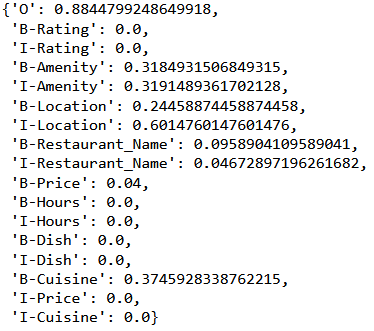

The model is performing similar then previous model but it's performence is slightly better than first model considering this task. It's better discriminating between tokens overall. The conclusion is not very well backed since the models were trained not on full data. Apart from 3 tokens I-Location, B-restaurants and I-Restaurant we see the significant increase in recall score. 

Based on the loss of model we could assume that this model should perform better then the first one. 